In [3]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scienceplots
plt.style.use(['science', 'grid'])

from phd.config import load_config, copy_config, apply_overrides
from phd.models.cm.analytical_plate import (
    train, exact_solution,
    plot_results, plot_compare, animate, subsample_frames, 
    load_run, save_run_data, continue_training, 
)
from phd.plot import book_config, get_current_config
book_config.set_as_current()

# Results directory (uses default: results/analytical_plate/{run_name})
save_fig = True
save_table = False

## Forward Problem
We train the model to solve the linear elasticity PDE given boundary conditions.

In [2]:
# === Forward Problem: SPINN/PINN × mixed/displacement ===

# Run configurations to train (empty list = load all from disk)
configs_to_run = []  # e.g. ["spinn_mixed", "spinn_disp", "pinn_mixed", "pinn_disp"]

# Load base config
base_cfg = load_config("analytical_plate")
base_cfg.task.type = "forward"
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "spinn_mixed": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
}

all_config_names = list(model_variants.keys())
results_forward = {}

# Text labels for plotting
config_text_dict = {
    "spinn_mixed": "SPINN (mixed)",
    "spinn_disp": "SPINN (disp.)",
    "pinn_mixed": "PINN (mixed)",
    "pinn_disp": "PINN (disp.)",
}

# === Train or Load each configuration ===
for config_name in all_config_names:
    run_name = config_name
    should_train = config_name in configs_to_run
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg)
        apply_overrides(cfg, model_variants[config_name])
        
        print(f"Training: {run_name}")
        results = train(cfg)
        
        # Save using problem-specific wrapper
        save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_forward[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_forward[run_name] = load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed


W1215 22:29:03.178402   86345 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 22:29:03.181444   86230 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp
Loading: pinn_mixed
Loading: pinn_disp


### Forward Results Visualization

In [ ]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history
from phd.io import save_df_to_latex

def build_results_df(all_data, config_text_dict=None, append_config=False):
    """Build a summary DataFrame from all_data dict."""
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        raw_runtime_metrics = entry.get("runtime_metrics", {})
        runtime_metrics = {}
        runtime_metrics["Time [m]"] = raw_runtime_metrics["elapsed_time"]/60
        runtime_metrics["Iter./s"] =raw_runtime_metrics["iterations_per_sec"]
        runtime_metrics["# Params"] = raw_runtime_metrics["net_params_count"]
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get formulation from config
        config = entry.get("config", {})
        # formulation = config.get("model", {}).get("formulation", "mixed")

        table_cfg = config if append_config else {}
        rows.append({
            "Model": name,
            # "formulation": formulation,
            **final_metrics,
            **runtime_metrics,
            **table_cfg,
        })            

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
df_results = build_results_df(results_forward, config_text_dict=config_text_dict)
display(
    df_results.style
    .background_gradient(subset=["L2 Error"], cmap="Greens_r")
    .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "Stress BC Loss", "Total Loss"])
    .format("{:.2f}", subset=["Time [m]", "Iter./s"])
    .format("{:.0f}", subset=["# Params"])
    .set_properties(subset=["Model"], **{"text-align": "left"})
)

# Save results table
if save_table:
    df_to_save = df_results[['Model', 'L2 Error', 'Total Loss', 'Time [m]', 'Iter./s', '# Params']]
    formatters = {
        "L2 Error": "{:.2e}",
        "Total Loss": "{:.2e}",
        "Time [m]": "{:.2f}",
        "Iter./s": "{:.2f}",
        "# Params": "{:.0f}",
    }
    save_df_to_latex(df_to_save, "./tables/forward_results.tex", formatters=formatters)

,model_name,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,elapsed_time,iterations_per_sec,net_params_count
0,PINN (disp.),2.10e-03,9.21e-04,nan,4.64e-04,5.47e-04,4.93,203.00,6234
1,SPINN (mixed),3.08e-03,5.18e-04,1.80e-04,nan,5.67e-04,1.30,767.58,12800
2,SPINN (disp.),4.98e-03,6.21e-03,nan,1.94e-03,2.72e-03,3.49,286.40,6464
3,PINN (mixed),4.99e-03,7.66e-04,3.51e-04,nan,9.23e-04,2.53,395.14,14045


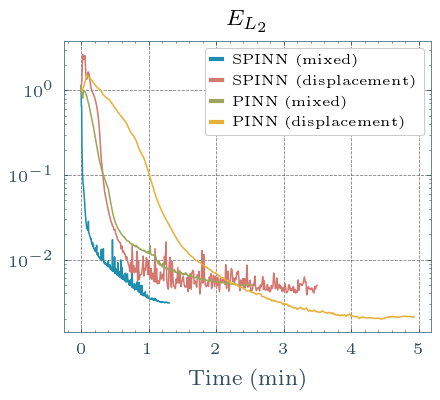

In [9]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

page_width = get_current_config().page_width
# Example usage with all forward results
if results_forward:
    fig, ax_l2 = plt.subplots(1, 1, figsize=(page_width*0.5, page_width * 0.4), dpi=200)
    plot_metrics_comparison(
        results_forward, metric_name="L2 Error", 
        run_names=[config_text_dict.get(k, k) for k in results_forward.keys()],
        step_type="time", time_unit="min", ylabel="", ax=ax_l2
    )
    ax_l2.set_title(r"$E_{L_2}$")

# 
# if save_fig:
    

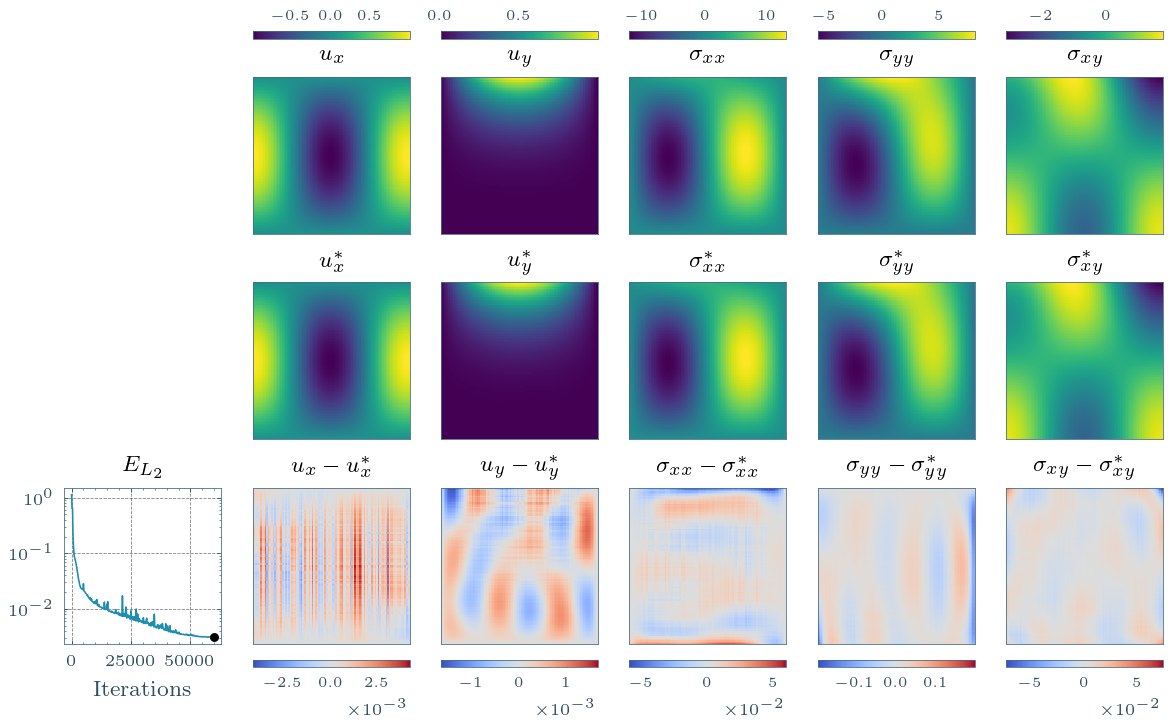

In [15]:
# === Plot single run results ===
from ipywidgets import interact, IntSlider

# Select which run to plot
run_to_plot = "spinn_mixed" 

if run_to_plot in results_forward:
    fig, artists = plot_results(results_forward[run_to_plot], iteration=-1, dpi=200)#, step_type="time", time_unit="sec")
    plt.show()
    
    # Uncomment to enable interactive plotting
    # n_steps = len(results_forward[run_to_plot]["callbacks"]["field_saver"].history)
    # @interact(frame_iter=IntSlider(min=0, max=n_steps-1, step=1, value=n_steps-1))
    # def plot_interactive(frame_iter):
    #     fig, artists = plot_results(results_forward[run_to_plot], iteration=frame_iter, dpi=200)
    #     plt.show()
else:
    print(f"Run '{run_to_plot}' not found in results_forward")

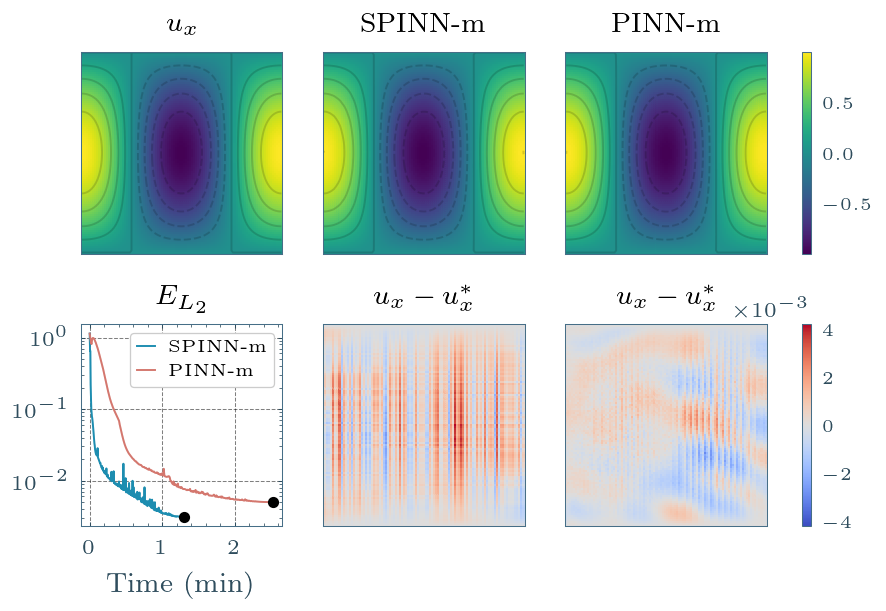

In [ ]:
# === Compare SPINN vs PINN (mixed formulation) ===

fields_to_compare = ["spinn_mixed", "pinn_mixed"] # ["spinn_disp", "pinn_disp", "spinn_mixed", "pinn_mixed"]

LATEX_FIELD_NAMES = {
    "spinn_disp": "SPINN-d",
    "pinn_disp": "PINN-d",
    "spinn_mixed": "SPINN-m",
    "pinn_mixed": "PINN-m",
}

get_current_config().min_font_size = 5

if all(field in results_forward for field in fields_to_compare):
    fig, artists = plot_compare(
        results_forward[fields_to_compare[0]],
        results_forward[fields_to_compare[1]],
        exact_solution_fn=exact_solution,
        run_names= [LATEX_FIELD_NAMES[field] for field in fields_to_compare],
        iteration=-1, dpi=250,
        step_type="time", time_unit="min", plot_contours=True
    )
    plt.show()
    
    if save_fig:
        fig.savefig("_vs_".join(fields_to_compare) + ".png", dpi=300)
else:
    print(f"Need both {fields_to_compare[0]} and {fields_to_compare[1]} to compare")

Subsampled from 300 to 120 frames
Animation preview:
  Total available frames: 300
  Selected frames: 120
  FPS: 10
  Duration: 12.0s


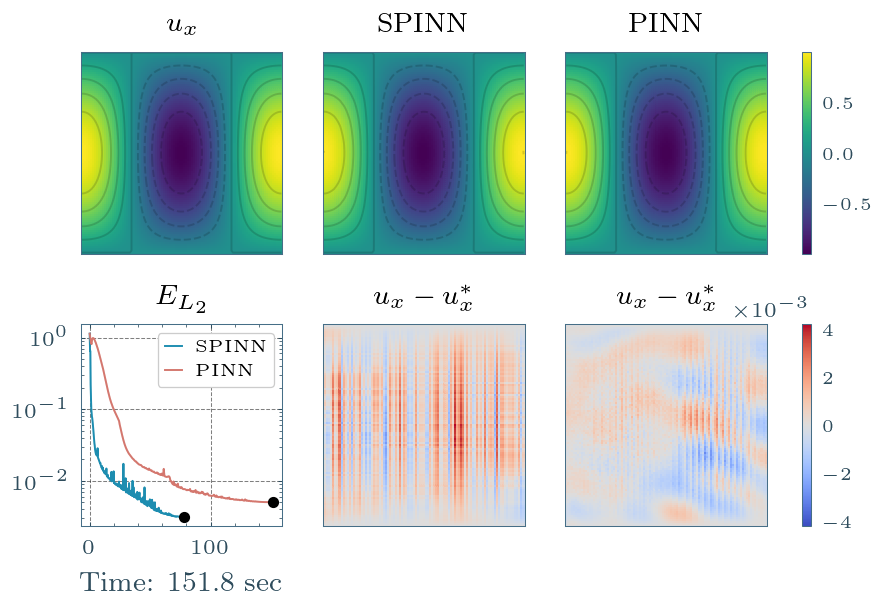

In [16]:
# Generate Animation for comparison
run_dir_forward = Path(results_forward["spinn_mixed"]["run_dir"])
video_path_forward = run_dir_forward / "training_animation.mp4"

fig, artists = plot_compare(
    results_forward["spinn_mixed"], 
    results_forward["pinn_mixed"],
    exact_solution_fn=exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
    show_iter=True
)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[1,2,3,4,4,4,4,4])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
# animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
# Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [2]:
# === Inverse Problem: SPINN/PINN × mixed/displacement + PINN enhanced ===
from phd.config import apply_overrides

# Run configurations to train (empty list = load all from disk)
configs_to_run_inverse = [] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]

# Load base config
base_cfg_inverse = load_config("analytical_plate")
base_cfg_inverse.task.type = "inverse"
base_cfg_inverse.training.n_iter = 60000
base_cfg_inverse.training.log_every = 200
base_cfg_inverse.seed = 0

# Define model variants (only the differences from base)
model_variants_inverse = {
    "spinn_mixed_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp_inv": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_enhanced_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],
        "model.architecture.width": 36,
        "task.inverse.training_factors.lmbd": 0.05,
        "task.inverse.training_factors.mu": 0.05,
    },
}

all_config_names_inverse = list(model_variants_inverse.keys())
results_inverse = {}

# Text labels for plotting
config_text_dict_inverse = {
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (displacement)",
    "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (displacement)",
    "pinn_enhanced_inv": "PINN (enhanced)",
}

# === Train or Load each configuration ===
for config_name in all_config_names_inverse:
    run_name = config_name
    should_train = config_name in configs_to_run_inverse
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg_inverse)
        apply_overrides(cfg, model_variants_inverse[config_name])
        
        print(f"Training: {run_name}")
        results = train(cfg)
        
        # Save using problem-specific wrapper
        save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_inverse[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_inverse[run_name] = load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed_inv


W1215 17:13:10.294000   81412 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 17:13:10.296441   81296 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp_inv
Loading: pinn_mixed_inv
Loading: pinn_disp_inv
Loading: pinn_enhanced_inv


### Inverse Results Visualization

In [ ]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history

def build_inverse_results_df(all_data, config_text_dict=None):
    """Build a summary DataFrame from inverse results."""
    rows = [

    ]
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        runtime_metrics = entry.get("runtime_metrics", {}).copy()
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        runtime_metrics["elapsed_time"] /= 60 # convert to minutes
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get material parameter discovery from variable callback
        var_cb = entry.get("callbacks", {}).get("variable_value", None)
        final_lmbd = np.nan
        final_mu = np.nan
        if var_cb and var_cb.history:
            var_hist = np.array(var_cb.history)
            final_lmbd = var_hist[-1, 1]  # Last value of lambda
            final_mu = var_hist[-1, 2]    # Last value of mu

        rows.append({
            "Model": name,
            **final_metrics,
            "final_λ": final_lmbd,
            "final_μ": final_mu,
            **runtime_metrics,
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
if results_inverse:
    df_results_inv = build_inverse_results_df(results_inverse, config_text_dict=config_text_dict_inverse)
    display(
        df_results_inv.style
        .background_gradient(subset=["L2 Error"], cmap="Greens_r")
        .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "DIC Loss","Total Loss"])
        .format("{:.4f}", subset=["final_λ", "final_μ"])
        .format("{:.2f}", subset=["iterations_per_sec", "elapsed_time"])
        .format("{:.0f}", subset=["net_params_count"])
        .set_properties(subset=["Model"], **{"text-align": "left"})
    )
else:
    print("No results loaded. Set configs_to_run_inverse or ensure saved runs exist.")

,model_name,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,DIC Loss,final_λ,final_μ,elapsed_time,iterations_per_sec,net_params_count
0,SPINN (mixed),4.10e-03,4.35e-04,2.84e-04,nan,5.03e-04,4.92e-07,1.0022,0.4995,3.29,303.79,12800
1,SPINN (displacement),4.08e-02,1.16e-02,nan,0.005015,5.89e-03,2.33e-04,0.9563,0.5474,4.66,214.73,6464
2,PINN (enhanced),6.08e-02,8.19e-04,2.80e-04,nan,4.46e-03,2.83e-04,0.8373,0.5540,4.06,246.28,14045
3,PINN (displacement),6.57e-02,1.29e-03,nan,0.005480,4.92e-03,6.53e-04,0.8798,0.6000,5.24,190.66,5618
4,PINN (mixed),1.38e+00,1.02e-03,7.82e-04,nan,9.74e-02,1.77e-02,-2.1231,1.9499,3.80,262.84,11205


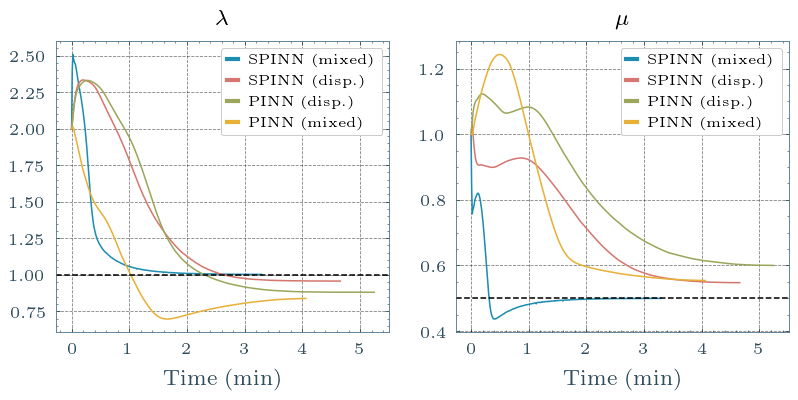

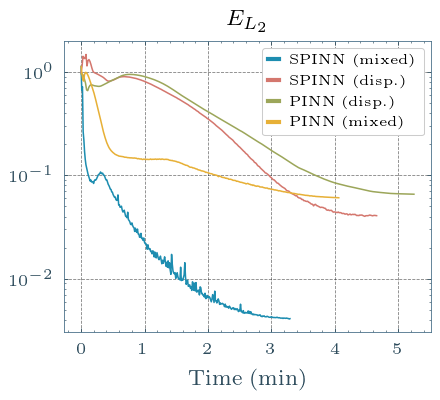

In [5]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

config_text_inv ={
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (disp.)",
    # "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (disp.)",
    "pinn_enhanced_inv": "PINN (mixed)",
}

# Create figure with 3 subplots
page_width = get_current_config().page_width
fig, axes = plt.subplots(1, 2, figsize=(page_width, page_width * 0.4), dpi=200)
ax_lmbd, ax_mu = axes



configs_to_plot = ["spinn_mixed_inv", "spinn_disp_inv", "pinn_disp_inv", "pinn_enhanced_inv"] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]
# Use available results
if results_inverse:
    results_to_plot = {k: results_inverse[k] for k in configs_to_plot if k in results_inverse}
    run_names_inv = [config_text_inv.get(k, k) for k in results_to_plot.keys()]

    # Plot Lambda
    plot_metrics_comparison(
        results_to_plot, metric_name="lambda", run_names=run_names_inv,
        step_type="time", time_unit="min", ax=ax_lmbd, ylabel=''
    )
    lmbd_true = results_to_plot["spinn_mixed_inv"]["config"]["problem"]["material"]["lmbd"]
    ax_lmbd.axhline(y=lmbd_true, linestyle='--', color='k', label="True")
    ax_lmbd.set_title(r"$\lambda$")

    # Plot Mu
    plot_metrics_comparison(
        results_to_plot, metric_name="mu", run_names=run_names_inv,
        step_type="time", time_unit="min", ax=ax_mu, ylabel=''
    )
    mu_true = results_to_plot["spinn_mixed_inv"]["config"]["problem"]["material"]["mu"]
    ax_mu.axhline(y=mu_true, linestyle='--', color='k', label="True")
    ax_mu.set_title(r"$\mu$")
    # ax_mu.legend()

    fig, ax_l2 = plt.subplots(1, 1, figsize=(page_width*0.5, page_width * 0.4), dpi=200)

    plot_metrics_comparison(
        results_to_plot, metric_name="L2 Error", run_names=run_names_inv,
        step_type="time", time_unit="min", ylabel="", ax=ax_l2
    )
    ax_l2.set_title(r"$E_{L_2}$")

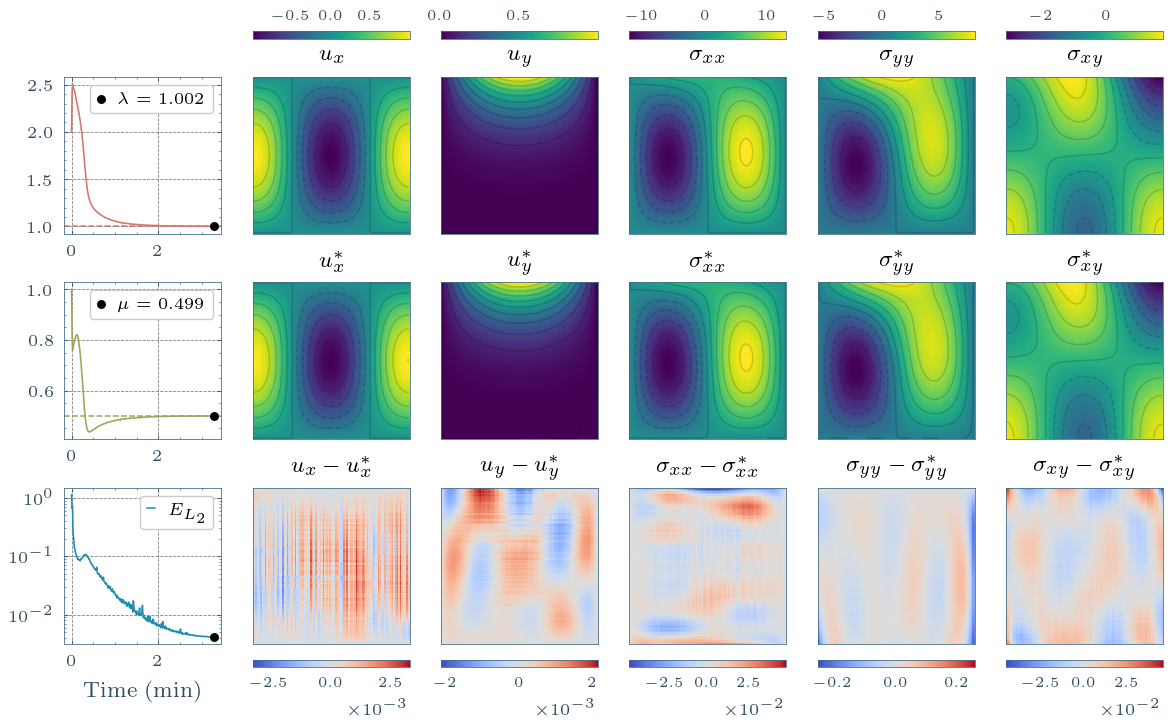

In [4]:
# === Plot single inverse run results ===
run_to_plot = "spinn_mixed_inv"  # Change to plot different configs

if run_to_plot in results_inverse:
    step = len(results_inverse[run_to_plot]["losshistory"].steps) - 2
    fig_inv, artists_inv = plot_results(results_inverse[run_to_plot], iteration=step, dpi=200, step_type="time", time_unit="min", plot_contours=True)

    if save_fig:
        run_dir = Path(results_inverse[run_to_plot]["run_dir"])
        fig_inv.savefig(run_dir / "inverse_results.png", dpi=300)
else:
    print(f"Run '{run_to_plot}' not found in results_inverse")

In [ ]:
# === Generate Animation for Inverse Problem ===
run_to_plot = "spinn_mixed"  # Change to different config for animation

if run_to_plot in results_inverse:
    fig_inv, artists_inv = plot_results(results_inverse[run_to_plot], iteration=0, dpi=200, step_type="time", time_unit="min", show_iter=True)
    
    video_path_inverse = Path(results_inverse[run_to_plot]["run_dir"]) / "training_animation.mp4"
    print("Generating animation...")

    # Custom frame subsampling - more detail at the beginning
    n_frames = len(artists_inv["steps"])
    frame_indices = subsample_frames(n_frames, factors=[1, 2, 3, 4, 5, 5, 5])

    # Preview
    animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices, preview=True)

    # Uncomment to save:
    # animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices)
    # Video(video_path_inverse, embed=True, html_attributes="controls loop autoplay")
else:
    print(f"Run '{run_to_plot}' not found in results_inverse")

Generating animation...
Animation preview:
  Total available frames: 300
  Selected frames: 117
  FPS: 10
  Duration: 11.7s
Animation saved to analytical_plate_results/SPINN_inverse/training_animation.mp4 (117 frames, 11.7s)
